In [1]:
import numpy as np
# import time

from hazma.scalar_mediator import ScalarMediator, HiggsPortal
from hazma.constraint_parameters import B_k_invis_obs, cm_to_inv_MeV, sv_inv_MeV_to_cm3_per_s
from hazma.gamma_ray_parameters import egret_diffuse
from utilities import latex_text_width_1col
from hazma.parameters import vh

import matplotlib.pyplot as plt

def get_tex_label(cn):
    if cn in ["CHARM"]:
        return cn
    else:
        tex_label = r"$"+ cn
        tex_label = tex_label.replace("B", "B^+")
        tex_label = tex_label.replace("pi ", "\pi^+ ")
        tex_label = tex_label.replace("pi0", "\pi^0")
        tex_label = tex_label.replace("kl", "K_L")
        tex_label = tex_label.replace("k", "K^+")
        tex_label = tex_label.replace("mu mu", "\mu^+ \mu^-")
        tex_label = tex_label.replace("e e", "e^+ e^-")
        tex_label = tex_label.replace("invis", "~\mathrm{invis.}")
        tex_label = tex_label.replace("->", "\\to")

        return tex_label + r"$"

def get_colors(cn):
    cns = ['B -> k mu mu', 'kl -> pi0 mu mu', 'B -> k e e', 'kl -> pi0 e e', 'k -> pi invis', 'B -> k invis', "CHARM"]
    
    return list(plt.rcParams["axes.prop_cycle"])[cns.index(cn)]["color"]

## Examples of subclassing to define custom parameters

In [16]:
from hazma.parameters import vh

class HiggsPortal(ScalarMediator):
    def __init__(self, mx, ms, st):
        self._stheta = st
        super(HiggsPortal, self).__init__(mx, ms, mx/vh*np.sqrt(1. - st**2), st, st, st)
        
    @property
    def stheta(self):
        return self._stheta
    
    @stheta.setter
    def stheta(self, st):
        self._stheta = st
        self.gsff = self._stheta
        self.gsFF = self._stheta
        self.gsGG = self._stheta
        self.gsxx = np.sqrt(1. - self._stheta**2)

# Compute constraints

In [10]:
sm_args = {"mx": 10000., "ms": 220., "gsxx": 1., "gsff": 1., "gsGG": 1., "gsFF": 1., "lam" : vh}
sm = ScalarMediator(**sm_args)

## Scan over two parameters

In [ ]:
from hazma.scalar_mediator import HiggsPortal

In [15]:
hp_args = {"mx":250., "ms":700., "gsxx": 1.0, "stheta" : 1e-3}
hp = HiggsPortal(**hp_args)

In [17]:
sm_args = {"mx": 10000., "ms": 220., "st": 1}
sm = HiggsPortal(**sm_args)

mss = np.logspace(1, 3, 150)
sthetas = np.logspace(np.log10(5.5e-6), 0, 160)

# Compute constraints
constr_imgs = sm.constrain("ms", mss, "st", sthetas)

TypeError: __init__() missing 1 required positional argument: 'lam'

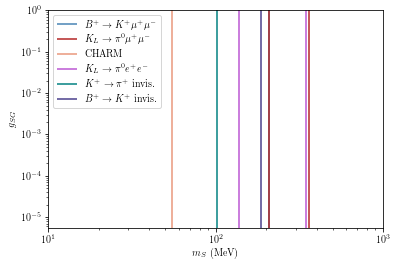

In [18]:
mss_mg, gsffs_mg = np.meshgrid(mss, sthetas)

for cn, img in constr_imgs.iteritems():
    cont = plt.contour(mss_mg, gsffs_mg, img, levels=[0],
                       colors=get_colors(cn))
    cont.collections[0].set_label(get_tex_label(cn))

# plt.grid()
plt.xlabel(r"$m_S$ (MeV)")
plt.ylabel(r"$g_{SG}$")
plt.legend(loc="upper left")
plt.xscale("log")
plt.yscale("log")

## Compute constraints over custom grid

In [22]:
fixed_params = {"mx": 200}
gsffs = np.logspace(np.log10(5.5e-6), np.log10(0.999), 150)
mss = np.logspace(1, 3, 150)

param_grid = np.empty((len(gsffs), len(mss)), dtype=np.object)
it = np.nditer(param_grid, flags=["multi_index", "refs_ok"], op_flags=["readwrite"])

while not it.finished:
    # sin(theta)
    sth = gsffs[it.multi_index[0]]
    it[0] = ScalarMediatorParameters(**dict(fixed_params,
                                            **{"gsxx": np.sqrt(1 - sth**2),
                                               "gsFF": sth, "gsGG": sth, "gsff": sth,
                                               "ms": mss[it.multi_index[1]]}))
    it.iternext()
    
# Compute constraints
constr_imgs = sm.custom_constrain(param_grid)

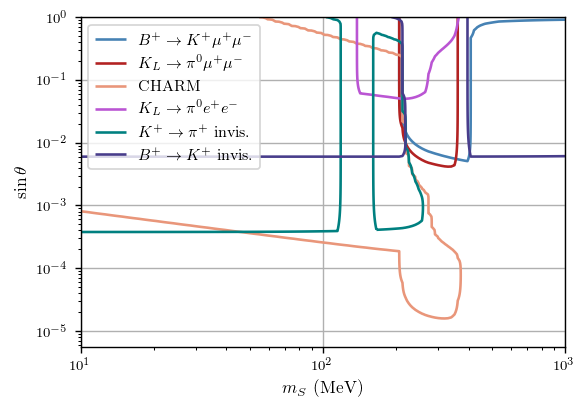

In [23]:
mss_mg, gsffs_mg = np.meshgrid(mss, gsffs)

for cn, img in constr_imgs.iteritems():
    cont = plt.contour(mss_mg, gsffs_mg, img, levels=[0], colors=get_colors(cn))
    cont.collections[0].set_label(get_tex_label(cn))

plt.grid()
plt.xlabel(r"$m_S$ (MeV)")
plt.ylabel(r"$\sin\theta$")
plt.legend(loc="upper left")
plt.xscale("log")
plt.yscale("log")

# Scratch

## Figuring out how to extract level sets

In [ ]:
from skimage import measure
import time

In [68]:
p1_vals = np.linspace(-4, 4, 400)
p2_vals = np.linspace(-2, 2, 200)
p1_mg, p2_mg = np.meshgrid(p1_vals, p2_vals)

# img = np.random.rand(21, 11)
img = np.sin(p1_mg**2 + p2_mg**2*p1_mg)

Took 0.013629 s to find contours


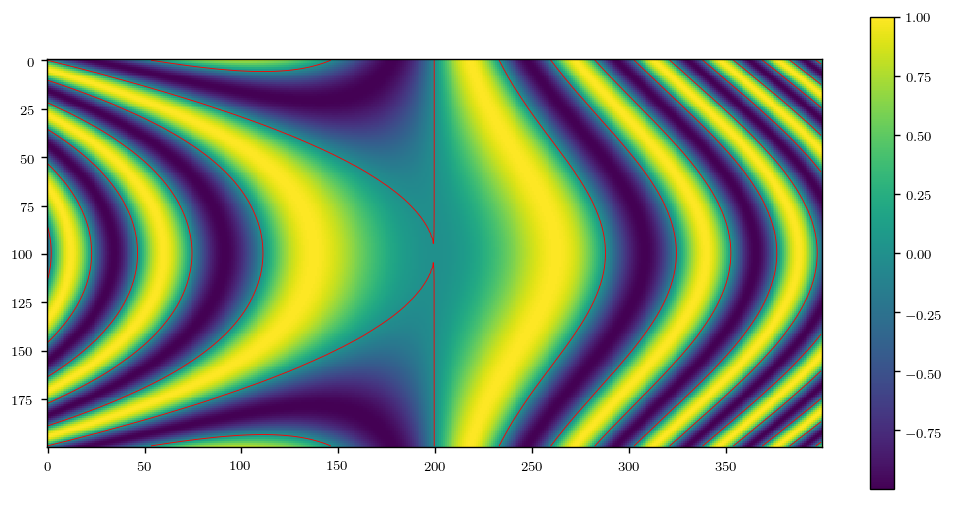

In [69]:
level = 0

plt.figure(figsize=(10, 5))

plt.imshow(img)
plt.colorbar()
##########
# plt.contour(p1_mg, p2_mg, img, levels=[level])
##########
ti = time.time()

contours = measure.find_contours(img, level)

tf = time.time()
print "Took %f s to find contours" % (tf - ti)
##########
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], '-r', linewidth=0.5, markersize=2)

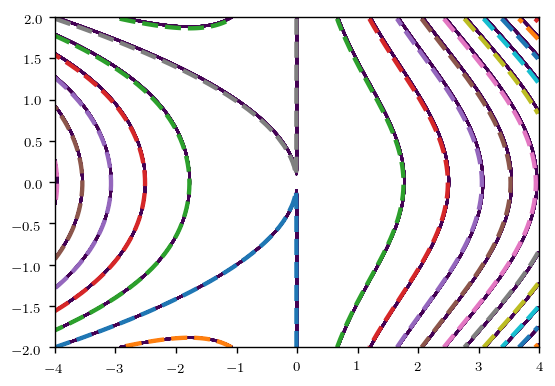

In [73]:
for contour in contours:
    xs = contour.T[1] / len(p1_vals) * (p1_vals[-1] - p1_vals[0]) + p1_vals[0]
    ys = contour.T[0] / len(p2_vals) * (p2_vals[-1] - p2_vals[0]) + p2_vals[0]
    plt.plot(xs, ys, '--', linewidth=2.5)
    plt.contour(p1_mg, p2_mg, img, levels=[0])

In [80]:
from hazma.parameters import charged_kaon_mass as mk, charged_pion_mass as mpi

In [82]:
[[max((mk**2 + mpi**2 - 2*mk*np.sqrt(mpi**2 + p**2))/mk**2, 0.0) for p in p_pis] for p_pis in [[229.0, 211.0], [195.0, 140.0]]]

[[0.0, 0.05503706441848837], [0.10844091096010344, 0.27905934475654287]]

In [90]:
(1+2j).conjugate()

(1-2j)

In [91]:
s_bounds = [[0., 10.**2], [20.**2, 30.**2]]

In [95]:
ms = 11.

np.any([s[0] <= ms**2 <= s[1] for s in s_bounds])

False

## Figuring out how to plot gamma ray constraints with other ones

### Computing $\langle \sigma v \rangle$

In [26]:
sm_args = {"mx": 150., "ms": 220., "gsxx": 1., "gsff": 1., "gsGG": 1., "gsFF": 1.}
sm = ScalarMediator(**sm_args)

mss = np.logspace(1, 3, 500)
vx = 1.0e-3

print sm.cross_sections(2*sm.mx*(1+0.5*vx**2))["total"] * vx / cm_to_inv_MeV**2 * 3e10

svs_gsff_fixed = []
for ms in mss:
    sm.ms = ms
    svs_gsff_fixed.append(sm.cross_sections(2*sm.mx*(1+0.5*vx**2))["total"] * vx / cm_to_inv_MeV**2 * 3e10)

7.89349256713e-30


Text(0,0.5,'$\\langle \\sigma v \\rangle$ (cm$^3$/s)')

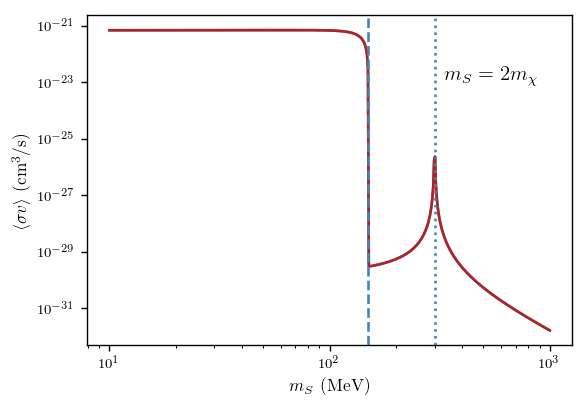

In [22]:
plt.loglog(mss, svs_gsff_fixed)
plt.loglog(mss, svs_gsff_fixed)
plt.axvline(2*sm.mx, linestyle=":")
plt.axvline(sm.mx, linestyle="--")
plt.text(3.3e2, 1e-23, r"$m_S = 2m_\chi$")

plt.xlabel(r"$m_S$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")

In [140]:
mss = np.logspace(1, 3, 150)
gsffs = np.logspace(np.log10(5.5e-6), 0, 160)

svs = np.zeros((len(gsffs), len(mss)))

for i, gsff in enumerate(gsffs):
    for j, ms in enumerate(mss):
        sm.gsff = gsff
        sm.ms = ms
        svs[i, j] = sm.cross_sections(2*sm.mx*(1+0.5*1e-6))["total"]*1e-3 / cm_to_inv_MeV**2 * 3e10

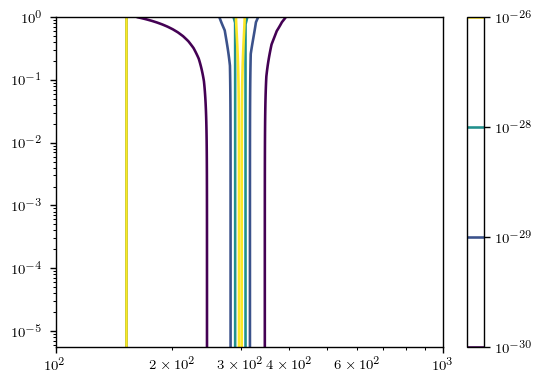

In [147]:
from matplotlib.colors import LogNorm

sv_cs = plt.contour(mss_mg, gsffs_mg, svs,
                    levels=[1e-30, 1e-29, 1e-28, 1e-26],
                    norm=LogNorm())
# plt.clabel(sv_cs, fontsize=10, fmt="%.1e")
plt.xlim(1e2, 1e3)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")

### Trying my new approach

In [95]:
sm_args = {"mx": 150., "ms": 1000., "gsxx": 1., "gsff": 1., "gsGG": 1., "gsFF": 1.}
sm = ScalarMediator(**sm_args)

vx = 1.0e-3
e_cm = lambda mx: 2*sm.mx*(1+0.5*vx**2)

mx_min, mx_max, n_mxs = 110., 250., 30
mxs = np.linspace(mx_min, mx_max, n_mxs)
gsxxs = np.logspace(2, 5, 30)

mxs_mg, gsxxs_mg = np.meshgrid(mxs, gsxxs)

Cross section at a benchmark point. VERY small...

In [96]:
print sm.cross_sections(e_cm(mx))["total"] * vx * sv_inv_MeV_to_cm3_per_s, "cm^3 / s"

1.64945058124e-32 cm^3 / s


In [ ]:
gamma_img = sm.constrain_gamma("mx", mxs, "gsxx", gsxxs, egret_diffuse)

In [4]:
# Compute limits on <sigma v>
svs = sm.binned_limits(mxs, egret_diffuse)

# Convert to limits on gsxx
gsxx_lims = []
for sv, mx in zip(svs, mxs):
    sm.mx = mx
    sm.gsxx = 1.
    gsxx_lims.append(np.sqrt(sv / (sm.cross_sections(e_cm(mx))["total"] * vx * sv_inv_MeV_to_cm3_per_s)))

Not good. The constraints on $g_{S\chi}$ are WAY above the perturbative unitarity bound...

(100.0, 200000.0)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


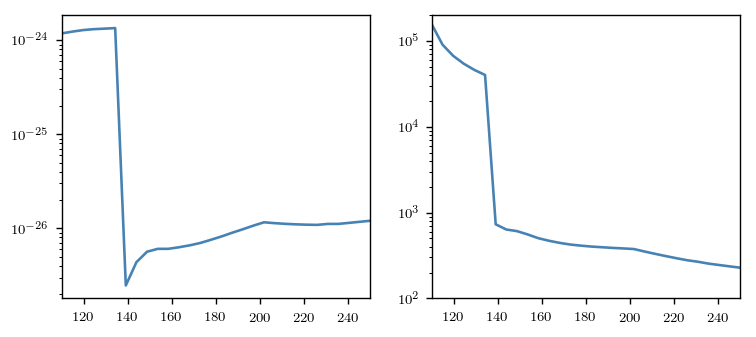

In [5]:
plt.figure(figsize=(7, 3))

plt.subplot(1, 2, 1)

plt.plot(mxs, svs)
plt.yscale("log")
plt.xlim(mxs[[0, -1]])

plt.subplot(1, 2, 2)

plt.plot(mxs, gsxx_lims)
plt.yscale("log")
plt.xlim(mxs[[0, -1]])
plt.ylim(1e2, 2e5)

#### Let's check how much flux we get in each of the EGRET bins with a large $g_{S\chi}$

In [85]:
from hazma.gamma_ray_limits.compute_limits import get_detected_spectrum

sm_args = {"mx": 150., "ms": 1000., "gsxx": 1., "gsff": 1., "gsGG": 1., "gsFF": 1.}
sm = ScalarMediator(**sm_args)

vx = 1.0e-3
e_cm = 2.*sm.mx*(1.+0.5*vx**2)

measurement = egret_diffuse

dm_flux_factor = (measurement.target.J * measurement.target.dOmega /
                  (2. * 4. * np.pi * sm.mx**2))

e_bin_min, e_bin_max = measurement.bins[0][0], measurement.bins[-1][1]

In [86]:
def get_bin_fluxes(spec_fn, line_fn):
    """Gets Phi/<sigma v> for a particular channel.
    """
    dnde_det = get_detected_spectrum(spec_fn, line_fn, e_bin_min,
                                     e_bin_max, e_cm,
                                     measurement.energy_res, 500)
    return np.array([dm_flux_factor*dnde_det.integral(bl, br)
                     for bl, br in measurement.bins])

def get_total_bin_fluxes(p2, p2_val):                                        
    """Computes total flux in each bin after setting p2 to p2_val.
    """                                                                 
    setattr(sm, p2, p2_val)                                           

    # Compute cross sections
    css = sm.cross_sections(e_cm)
    # Get fluxes by multiplying <sigma v>
    bin_fluxes = np.array([bf * css[fs] * vx * sv_inv_MeV_to_cm3_per_s
                           for fs, bf in fs_bin_fluxes.iteritems()])
    return bin_fluxes.sum(axis=0)

In [87]:
flux_obs = measurement.target.dOmega * (measurement.bins[:, 1] - measurement.bins[:, 0]) * measurement.fluxes

Text(0,0.5,'Flux')

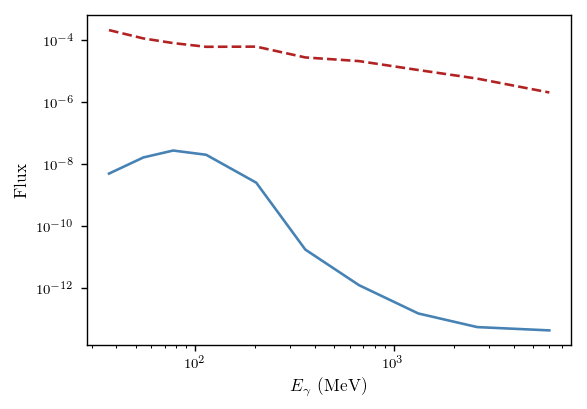

In [91]:
plt.plot(np.mean(measurement.bins, axis=1), get_total_bin_fluxes("gsxx", 4*np.pi), label=r"$g_{S\chi} = 4 \pi$")
plt.plot(np.mean(measurement.bins, axis=1), flux_obs, '--', label="EGRET (obs)")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$E_\gamma$ (MeV)")
plt.ylabel(r"Flux")

#### Checking the cross section at the benchmark point for the vector model

In [92]:
from hazma.vector_mediator import VectorMediator

In [98]:
vm = VectorMediator(mx=150., mv=1e3, gvxx=0.001, gvuu=1, gvdd=0.2, gvss=0., gvee=0., gvmumu=0.)

vx = 1.0e-3
e_cm = 2.*sm.mx*(1.+0.5*vx**2)

print vm.cross_sections(e_cm)["total"] * vx * sv_inv_MeV_to_cm3_per_s, "cm^3 / s"

3.9869900574687132e-28 cm^3 / s
